Load the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\Surface\Masterarbeit')
%matplotlib inline

#path = r"C:\Users\Surface\Masterarbeit\data\FEM_Daten\Baseline.xlsx"
path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn5.xlsx"

df = pd.read_excel(path)


Transformation Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import prep
import importlib
importlib.reload(prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# print the shapes of the data
print(data_num.shape, X_train.shape, X_val.shape, X_test.shape)

RQF Implementation with quantile-forest according to Mainhausen (2006) paper https://zillow.github.io/quantile-forest/gallery/plot_qrf_prediction_intervals.html

In [11]:
from quantile_forest import RandomForestQuantileRegressor
#define model, 200 different trees, max_depth of 8 delivers the best coverage and R² Score
qrf = RandomForestQuantileRegressor(n_estimators=500, max_depth=10, n_jobs=-1, random_state=42)

#train model
qrf.fit(X_train, y_train)

RandomForestQuantileRegressor(max_depth=10, n_estimators=500, n_jobs=-1,
                              random_state=42)

Mean Squared Error on Train Data: 7.423
R² on Train Data: 0.873
Mean Squared Error on Test Data: 9.351
R² on Test Data: 0.836
Coverage: 99.00%


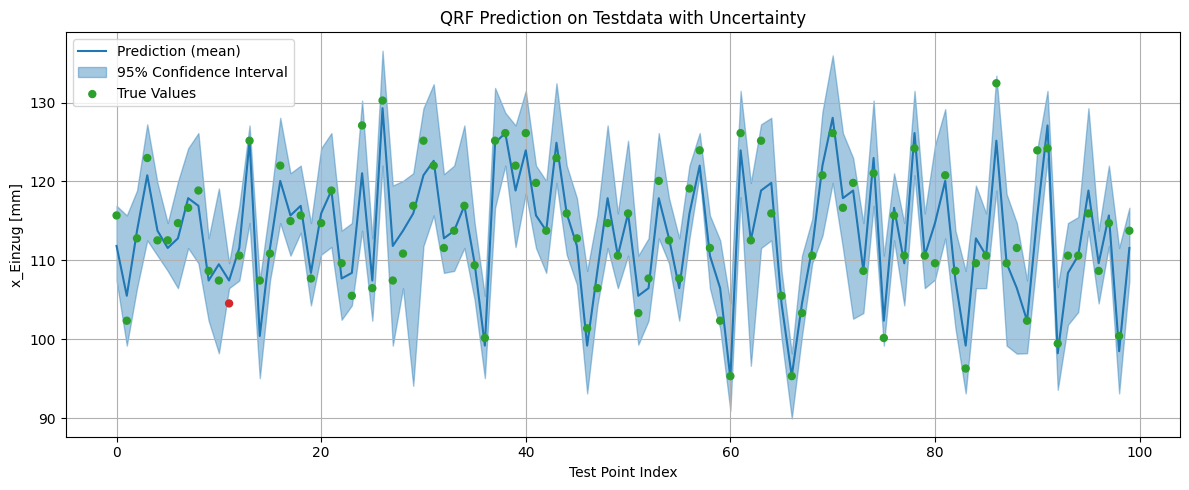

In [12]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#! handling the train data
#make predicitons on train dataset
y_train_pred_rqf = qrf.predict(X_train, quantiles=[0.025, 0.5, 0.975])
#calculate MSE and R2 Score for train data
mse_train_rqf = mean_squared_error(y_train, y_train_pred_rqf[:, 1])
r2_train_rqf = r2_score(y_train, y_train_pred_rqf[:, 1])
print(f"Mean Squared Error on Train Data: {mse_train_rqf:.3f}")
print(f"R² on Train Data: {r2_train_rqf:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Make predictions on test dataset
y_test_pred_rqf = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])
# Calculate MSE and R² Score for test data
mse_test_rqf = mean_squared_error(y_test, y_test_pred_rqf[:, 1])
r2_test_rqf = r2_score(y_test, y_test_pred_rqf[:, 1])

print(f"Mean Squared Error on Test Data: {mse_test_rqf:.3f}")
print(f"R² on Test Data: {r2_test_rqf:.3f}")

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= y_test_pred_rqf[random_indices, 0]) & (y_test[random_indices] <= y_test_pred_rqf[random_indices, 2])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, y_test_pred_rqf[random_indices, 1], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, y_test_pred_rqf[random_indices, 0], y_test_pred_rqf[random_indices, 2],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("QRF Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model Testing Random Forest


In [13]:
from sklearn.ensemble import RandomForestRegressor

#define model, 50 different trees
rnd_reg = RandomForestRegressor(n_estimators=500, max_depth=  10, n_jobs=-1)
#train model
rnd_reg.fit(X_train, y_train)

#prepare a data frame for the important features
importances = rnd_reg.feature_importances_
features = feature_names

# Create a DataFrame to display feature importance, sorted descending
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(feat_df)

#make some predicitons on train and test dataset
y_train_pred = rnd_reg.predict(X_train)
y_test_pred = rnd_reg.predict(X_test)

#calculate R2 Score for train and test data
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 Score Train: {r2_train:.3f}, Test: {r2_test:.3f}")


,Feature,Importance
26,week_sin,0.289754
27,week_cos,0.119010
1,K1,0.095483
38,STP_NR_freq,0.072542
10,PP_10,0.063682
5,K8,0.046343
22,day_sin,0.043869
13,RF_10,0.029877
14,TD_10,0.025528
23,day_cos,0.025489


R2 Score Train: 0.873, Test: 0.842
